# Strengthening Loan Amount Estimation with Adversarial Training and Conformal Prediction

#### Trustworthy AI Examples Series

This notebook examines vulnerabilities in loan amount prediction systems, particularly their susceptibility to adversarial manipulation and income-related outliers. Using the German Credit dataset, it constructs a robust decision pipeline that combines Isolation Forests for anomaly detection, Projected Gradient Descent (PGD)-hardened models, and conformal prediction analysis to increase reliability in loan amount modeling.

Loan sizing models can be exploited by strategic feature manipulation to obtain inflated loan offers. Additionally, income volatility among freelancers and gig workers can trigger inaccurate loan amount predictions, which pose financial risks to lenders and may unfairly penalize non-traditional borrowers. To address robustness concerns, this pipeline simulates adversarial attacks and income distribution shifts and measures performance degradation through prediction error across housing types and confidence intervals for loan offers.

Through this scenario, readers will:

1. **Understand the real-world stakes**: how adversarial feature engineering exploits model blind spots.
2. **Learn to construct end-to-end AI pipelines**: from adversarial validation to selective prediction thresholds.
3. **Apply robustness strategies in-context**: implement targeted PGD training and integrate domain-specific constraints or transformations to simulate realistic adversarial perturbations.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches

from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import python.utils.preprocessing as pp

### Set Manual Seed

Setting seeds for random operations allows for reproducible results, which are used within this notebook.

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Data Preparation

In order to train a model on the German Credit Data dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [4]:
file_path = PROJECT_ROOT / 'data/german_credit_data.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Credit amount'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize')

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1]}")

Training set size: 800 samples
Test set size: 200 samples
Number of features: 9


## Isolation Forest Anomaly Detection

This section uses an Isolation Forest to identify outliers in the training data, particularly those that may distort model learning due to income volatility or unusual feature combinations. The `contamination` parameter assumes roughly 10% of the data may be anomalous, which is a reasonable starting point for financial datasets. The anomaly scores are visualized in a histogram, revealing that most scores cluster between 0 and 0.15, with a peak near 0.10. This shows that the majority of samples are considered normal or only mildly anomalous. The few negative scores suggest a small subset of strongly anomalous data points, which are filtered out to create a cleaner training set for robustness benchmarking.

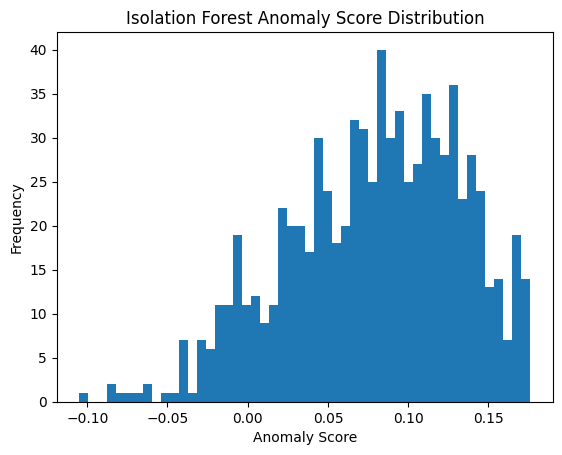

In [5]:
iso = IsolationForest(contamination=0.1, random_state=42)

anomaly_labels = iso.fit_predict(X_train.values)
anomaly_scores = iso.decision_function(X_train.values)

plt.hist(anomaly_scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

### Outlier Removal

Using Isolation Forest before PGD simulation is crucial because it helps ensure that the model is trained and evaluated on a dataset that reflects realistic trends. PGD attacks are designed to find minimal perturbations that fool a model into making bad predictions. If the dataset has significant outliers, PGD might "exploit" those unusual distributions rather than simulating meaningful adversarial attacks, leading to unrealistic adversarial examples and poor generalization.

In [6]:
X_train_clean = X_train[anomaly_labels == 1]
y_train_clean = y_train[anomaly_labels == 1]

print(f"Original training set: {X_train.shape[0]} samples")
print(f"Cleaned training set after outlier removal: {X_train_clean.shape[0]} samples")

Original training set: 800 samples
Cleaned training set after outlier removal: 720 samples


## PGD Attack Simulation

This function simulates adversarial manipulation by applying Projected Gradient Descent to perturb input features in a direction that maximizes prediction error. It computes gradients with respect to the input using PyTorch’s autograd system, then iteratively adjusts the input within a bounded epsilon range to simulate realistic feature tampering. This approach helps evaluate how vulnerable the model is to strategic manipulation, such as applicants inflating income or tweaking housing status to game the loan prediction system. The resulting adversarial examples are used both for testing and for adversarial training.

In [7]:
def pgd_attack(model, X, y, epsilon=0.1, alpha=0.01, num_iter=10):
    model.eval()
    X_adv = torch.tensor(X.values, dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    for _ in range(num_iter):
        outputs = model(X_adv)
        loss = nn.MSELoss()(outputs, y_tensor)
        loss.backward()
        X_adv.data += alpha * X_adv.grad.sign()
        X_adv.data = torch.clamp(X_adv.data, X_adv.data - epsilon, X_adv.data + epsilon)
        X_adv.grad.zero_()
    return X_adv.detach().numpy()

## Regression Neural Network

The `Regressor` class defines a simple feedforward neural network with two hidden layers and ReLU activations, designed to predict continuous credit amounts. The final output layer produces a single scalar prediction, which is optimized using mean squared error. This model serves as the backbone for both the baseline and PGD-hardened regressors, allowing for consistency across robustness strategies.

In [8]:
class Regressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

### Training Function

This function trains the neural network using the Adam optimizer and mean squared error loss over 100 epochs. It converts the input features and targets into PyTorch tensors and performs standard gradient descent updates. The training loop is designed to be flexible and reusable across different model variants, including clean and adversarially augmented datasets. By keeping the training logic modular, the pipeline supports easy experimentation with PGD-hardening.

In [9]:
def train_model(model, X, y, epochs=100, lr=0.001):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = loss_fn(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    return model

## Baseline Model

The baseline model is trained on a cleaned subset of the training data using a neural network regressor. After training, it is evaluated on a PGD-attacked test set to simulate adversarial manipulation. The baseline model achieves an RMSE of 0.785, MAE of 0.595, and R² of 0.194, indicating moderate accuracy but limited robustness under adversarially perturbed inputs. Lower RMSE and MAE values mean the model recommends loan amounts closer to actual values, which is essential for avoiding financial loss from over- or under-lending.

In [10]:
baseline_model = Regressor(input_dim=X_train_clean.shape[1])
baseline_model = train_model(baseline_model, X_train_clean, y_train_clean)

X_test_adv = pgd_attack(baseline_model, X_test, y_test)
y_pred_baseline = baseline_model(torch.tensor(X_test_adv, dtype=torch.float32)).detach().numpy()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print("=== Baseline Model ===")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

=== Baseline Model ===
RMSE: 0.785
MAE: 0.595
R²: 0.194


## PGD-Hardened Model

To improve robustness, the PGD-hardened model is trained on a combination of clean and adversarially-perturbed training data. The PGD attack introduces controlled feature shifts with a perturbation magnitude of 0.095 (~9.5% deviation from original distribution), simulating realistic manipulation scenarios.

The hardened model achieves an RMSE of 0.722, MAE of 0.530, and R² of 0.318 on the same PGD-attacked test set, demonstrating improved resilience and predictive fidelity. This approach shows how adversarial training can effectively mitigate vulnerability to strategic feature manipulation in loan amount prediction systems.

In [11]:
X_train_adv = pgd_attack(baseline_model, X_train_clean, y_train_clean)
X_train_combined = np.vstack([X_train_clean.values, X_train_adv])
y_train_combined = np.concatenate([y_train_clean.values, y_train_clean.values])

print("PGD perturbation magnitude:", np.mean(np.abs(X_train_adv - X_train_clean.values)))

hardened_model = Regressor(input_dim=X_train_combined.shape[1])
hardened_model = train_model(hardened_model, pd.DataFrame(X_train_combined), pd.Series(y_train_combined))

y_pred_hardened = hardened_model(torch.tensor(X_test_adv, dtype=torch.float32)).detach().numpy()

rmse_pgd = np.sqrt(mean_squared_error(y_test, y_pred_hardened))
mae_pgd = mean_absolute_error(y_test, y_pred_hardened)
r2_pgd = r2_score(y_test, y_pred_hardened)

print("\n=== Hardened Model ===")
print(f"RMSE: {rmse_pgd:.3f}")
print(f"MAE: {mae_pgd:.3f}")
print(f"R²: {r2_pgd:.3f}")

PGD perturbation magnitude: 0.09559880497195318

=== Hardened Model ===
RMSE: 0.722
MAE: 0.530
R²: 0.318


## Comparison

### Metric Performance

This bar chart compares the RMSE, MAE, and R² scores of the baseline and PGD-hardened models. Each metric is color-coded and displayed side-by-side for both models, making it easy to visually assess performance differences. The PGD-hardened model consistently shows lower error metrics and a higher R², indicating improved robustness and predictive accuracy under adversarial conditions. The visualization reinforces the effectiveness of adversarial training in mitigating manipulation risks in loan amount prediction.

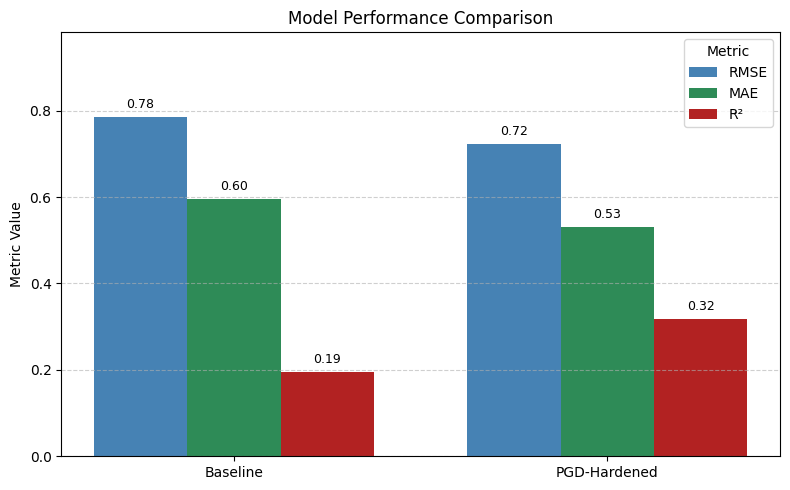

In [12]:
metrics_comparison = pd.DataFrame({
    'RMSE': [rmse, rmse_pgd],
    'MAE': [mae, mae_pgd],
    'R²': [r2, r2_pgd]
}, index=['Baseline', 'PGD-Hardened'])

colors = ['steelblue', 'seagreen', 'firebrick']
bar_width = 0.25
x = np.arange(len(metrics_comparison.index))

fig, ax = plt.subplots(figsize=(8, 5))

for i, (metric, color) in enumerate(zip(metrics_comparison.columns, colors)):
    values = metrics_comparison[metric]
    bar_positions = x + i * bar_width
    ax.bar(bar_positions, values, width=bar_width, label=metric, color=color)
    for xi, val in zip(bar_positions, values):
        ax.text(xi, val + 0.015, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics_comparison.index)
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Comparison')
ax.set_ylim(0, metrics_comparison.max().max() * 1.25)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(title='Metric')
plt.tight_layout()
plt.show()

### Conformal Prediction Visualization

These line plots show the true vs predicted credit amounts for both models, with shaded bands representing 95% conformal prediction intervals. The baseline model’s intervals are relatively tight and mostly contain the true values, indicating good calibration. The PGD-hardened model’s intervals are slightly wider but still maintain strong coverage, reflecting its ability to remain confident even under adversarial stress.

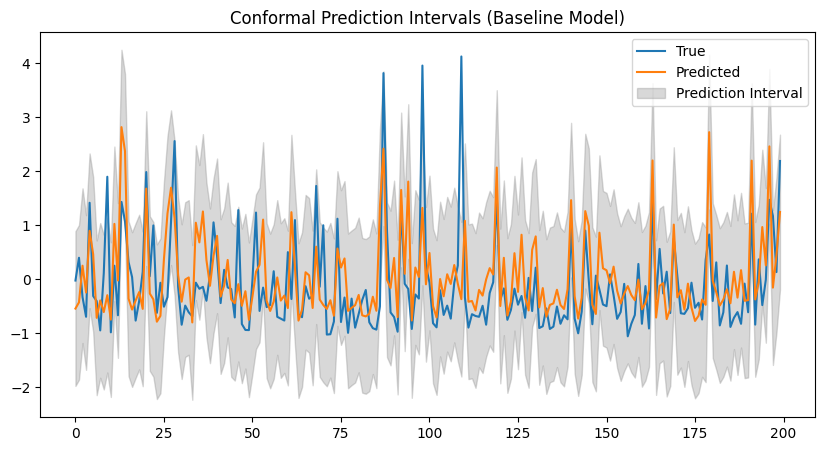

In [13]:
residuals = np.abs(y_train_clean.values - baseline_model(torch.tensor(X_train_clean.values, dtype=torch.float32)).detach().numpy().flatten())
quantile = np.quantile(residuals, 0.95)

y_pred_lower = y_pred_baseline.flatten() - quantile
y_pred_upper = y_pred_baseline.flatten() + quantile

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='True')
plt.plot(y_pred_baseline.flatten(), label='Predicted')
plt.fill_between(range(len(y_test)), y_pred_lower, y_pred_upper, color='gray', alpha=0.3, label='Prediction Interval')
plt.legend()
plt.title("Conformal Prediction Intervals (Baseline Model)")
plt.show()

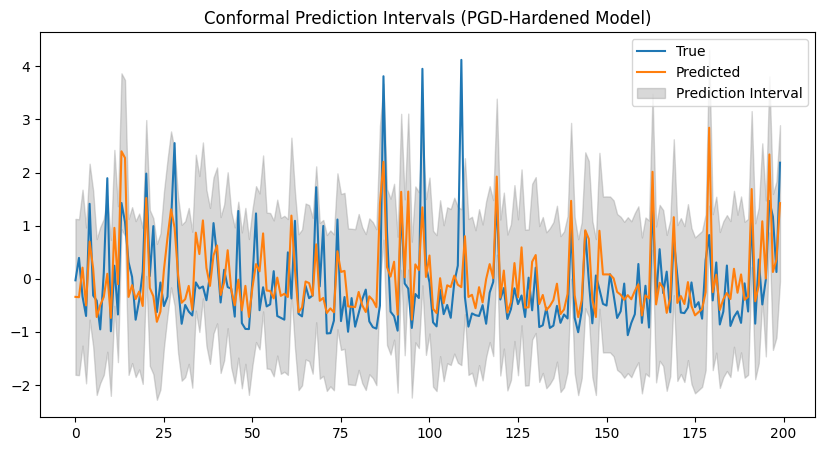

In [14]:
residuals_hardened = np.abs(
    y_train_clean.values - hardened_model(torch.tensor(X_train_clean.values, dtype=torch.float32)).detach().numpy().flatten()
)
quantile_hardened = np.quantile(residuals_hardened, 0.95)

y_pred_lower_hardened = y_pred_hardened.flatten() - quantile_hardened
y_pred_upper_hardened = y_pred_hardened.flatten() + quantile_hardened

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='True')
plt.plot(y_pred_hardened.flatten(), label='Predicted')
plt.fill_between(range(len(y_test)), y_pred_lower_hardened, y_pred_upper_hardened, color='gray', alpha=0.3, label='Prediction Interval')
plt.legend()
plt.title("Conformal Prediction Intervals (PGD-Hardened Model)")
plt.show()

### Coverage Rate and Average Prediction Interval Width

This section quantifies the reliability of each model’s predictions by comparing coverage rates and average interval widths. Similar to what was seen in the visualization above, the PGD-hardened model achieves slightly higher prediction intervals (2.935) than the baseline (2.864). This indicates that adversarial training may improve robustness while also enhancing confidence calibration, enabling the model to express uncertainty more effectively. Ideally, improvements in technique should not significantly increase interval width if coverage remains consistent.

In [15]:
def compute_mean_width(model, X_train, y_train, y_pred_test):
    preds_train = model(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().flatten()
    residuals = np.abs(y_train.values - preds_train)
    quantile = np.quantile(residuals, 0.95)
    lower = y_pred_test.flatten() - quantile
    upper = y_pred_test.flatten() + quantile
    widths = upper - lower
    return np.mean(widths)

coverage = np.mean((y_test.values >= y_pred_lower) & (y_test.values <= y_pred_upper))
coverage_hardened = np.mean((y_test.values >= y_pred_lower_hardened) & (y_test.values <= y_pred_upper_hardened))

mean_width_b = compute_mean_width(baseline_model, X_train_clean, y_train_clean, y_pred_baseline)
mean_width_h = compute_mean_width(hardened_model, X_train_clean, y_train_clean, y_pred_hardened)

print("Coverage / Rejection Rate:")
print(f"Baseline Model: {coverage:.3f} | {1 - coverage:.3f}")
print(f"Hardened Model: {coverage_hardened:.3f} | {1 - coverage_hardened:.3f}")

print("\nMean Prediction Interval Widths:")
print(f"Baseline Model: {mean_width_b:.3f}")
print(f"Hardened Model: {mean_width_h:.3f}")

Coverage / Rejection Rate:
Baseline Model: 0.950 | 0.050
Hardened Model: 0.950 | 0.050

Mean Prediction Interval Widths:
Baseline Model: 2.864
Hardened Model: 2.935


### Prediction Error Distribution by Housing Type

This boxplot visualization compares absolute prediction errors across three housing types for both models. The PGD-hardened model consistently shows narrower interquartile ranges and fewer outliers, especially for Housing Types 2 and 3, indicating more stable and reliable predictions. While median errors are similar, the reduced variability in the hardened model highlights its resilience to income-related feature shifts and adversarial manipulation. Overall, these results underscore the importance of robustness in protecting vulnerable borrower groups.

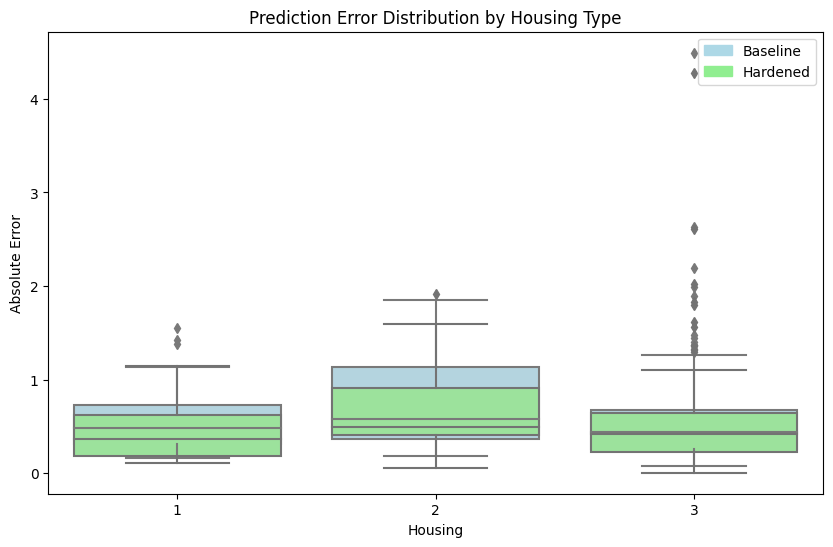

Average Prediction Error by Housing Type:
   Housing  Baseline Error  Hardened Error
0        1        0.584537        0.446677
1        2        0.780782        0.691648
2        3        0.570691        0.528270


In [16]:
housing_test = df.loc[X_test.index, 'Housing']
df_eval = pd.DataFrame({
    'Housing': housing_test.values,
    'True': y_test.values,
    'Baseline': y_pred_baseline.flatten(),
    'Hardened': y_pred_hardened.flatten()
})

df_eval['Baseline Error'] = np.abs(df_eval['True'] - df_eval['Baseline'])
df_eval['Hardened Error'] = np.abs(df_eval['True'] - df_eval['Hardened'])

grouped = df_eval.groupby('Housing')[['Baseline Error', 'Hardened Error']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_eval, x='Housing', y='Baseline Error', color='lightblue')
sns.boxplot(data=df_eval, x='Housing', y='Hardened Error', color='lightgreen')

baseline_patch = mpatches.Patch(color='lightblue', label='Baseline')
hardened_patch = mpatches.Patch(color='lightgreen', label='Hardened')
plt.legend(handles=[baseline_patch, hardened_patch])

plt.title("Prediction Error Distribution by Housing Type")
plt.ylabel("Absolute Error")
plt.show()

print("Average Prediction Error by Housing Type:")
print(grouped)

## Takeaways

This pipeline demonstrates a robust approach to loan amount prediction under adversarial and uncertain conditions. By combining Isolation Forest anomaly detection, PGD adversarial training, and conformal prediction, it effectively identifies outliers, defends against strategic feature manipulation, and flags low-confidence predictions. The PGD-hardened model consistently outperforms the baseline in terms of error metrics and confidence calibration, showing improved resilience and reliability. Visual comparisons across metrics, prediction intervals, and housing-type error distributions reinforce the value of robustness techniques in protecting lenders and ensuring equity for non-traditional borrowers.